In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from a345_utilities import print_header, mem_usage     
from matplotlib.patches import Rectangle as rect 
import numpy as np
import os, time
from photutils import DAOStarFinder
from astropy.stats import mad_std
from photutils import aperture_photometry, CircularAperture
from a345_utilities import print_header 
from photutils import DAOStarFinder
from photutils.detection import DAOStarFinder
from astropy.stats import mad_std
from astropy.coordinates import SkyCoord
from photutils import CircularAnnulus
from scipy.optimize import curve_fit
from astropy.modeling import models, fitting
from astropy.time import Time
import re
import warnings
warnings.filterwarnings('ignore')
from astropy.stats import sigma_clipped_stats
import pandas as pd
from astroquery.astrometry_net import AstrometryNet
from astroquery.exceptions import TimeoutError
plt.style.use('report.mplstyle')

path_cal = '/Volumes/external_2T/calibration/2023-10/neg10c/master'
path_data =  '/Volumes/external_2T'


/var/folders/tn/fqh6631n3p56r504tcsqvss00000gn/T/ipykernel_69968/2120195264.py:10: DeprecationWarning: `photutils.DAOStarFinder` is a deprecated alias for `photutils.detection.DAOStarFinder` and will be removed in the future. Instead, please use `from photutils.detection import DAOStarFinder` to silence this warning.
  from photutils import DAOStarFinder
/var/folders/tn/fqh6631n3p56r504tcsqvss00000gn/T/ipykernel_69968/2120195264.py:12: DeprecationWarning: `photutils.aperture_photometry` is a deprecated alias for `photutils.aperture.aperture_photometry` and will be removed in the future. Instead, please use `from photutils.aperture import aperture_photometry` to silence this warning.
  from photutils import aperture_photometry, CircularAperture
/var/folders/tn/fqh6631n3p56r504tcsqvss00000gn/T/ipykernel_69968/2120195264.py:12: DeprecationWarning: `photutils.CircularAperture` is a deprecated alias for `photutils.aperture.CircularAperture` and will be removed in the future. Instead, please

In [2]:
def calibration(star, band , exposure, six_x_six: bool = True):
    
    '''This function calibrates the images of a star in a given band and exposure time.
    
    
    Parameters:
    -----------
    star : str
        Name of the star.
    band : str
        Band of the images.
    exposure : str
        Exposure time of the images.
    six_x_six : bool
        If True, the function will use the 6x6 images, otherwise it will use the 1x1 images.
        '''
    counter = 0
    
    if six_x_six == True:
        path_cal = '/Volumes/external_2T/6x6_cal/master'
        path_data =  '/Volumes/external_2T'
    else:
        path_cal = '/Volumes/external_2T/calibration/2023-10/neg10c/master'
        path_data =  '/Volumes/external_2T'
    
    
    with fits.open(path_cal+'/dark_flat_gr_3s_master.fits') as hdu:
        flatdark_data = hdu[0].data
    
    with fits.open(path_cal+'/dark_'+exposure+'_master.fits') as hdu:
        dark_data = hdu[0].data

    if re.search('G',band):
        with fits.open(path_cal+'/flat_g_master.fits') as hdu:
            flat = hdu[0].data      
    
    if re.search('I',band):
        with fits.open(path_cal+'/flat_i_master.fits') as hdu:
            flat = hdu[0].data 
    
    if re.search('R',band):
        with fits.open(path_cal+'/flat_r_master.fits') as hdu:
            flat = hdu[0].data 
    
    star_list = os.listdir(path_data+'/'+star+'/'+band)       

    for img in star_list:
        print(img)

            
        if img.endswith('.fits'):          
            with fits.open(path_data+'/'+star+'/'+band+'/'+img) as hdu:
                img_header = hdu[0].header
                img_data = hdu[0].data
            if re.search('_E_',img):
                img_data = np.rot90(img_data, k=2)

            img_c = (img_data-dark_data)*(np.mean(flat-flatdark_data))/(flat-flatdark_data)
            if counter == 0:
                plt.figure(figsize=(10,10))
                plt.imshow(img_c, cmap='gray', origin='lower')
                plt.colorbar()
                plt.title('Corrected image')
                plt.show()
                counter += 1
            hdu = fits.PrimaryHDU(img_c)
            hdu.header = img_header
            if six_x_six == True:
                if not os.path.exists(path_data+'/corrected/6x6/'+star+'/'+band):
                    os.makedirs(path_data+'/corrected/6x6/'+star+'/'+band)
                hdu.writeto(path_data+'/corrected/6x6/'+star+'/'+band+'/'+img+'_c.fits',overwrite=True)
            else:
                if not os.path.exists(path_data+'/corrected/'+star+'/'+band):
                    os.makedirs(path_data+'/corrected/'+star+'/'+band)
                hdu.writeto(path_data+'/corrected/'+star+'/'+band+'/'+img+'_c.fits',overwrite=True)
            
            


In [20]:
def platesolve(star,band,solver:bool = True, six_x_six: bool = True):
    
    '''This function platesolves the images of a star in a given band.
    
    
    Parameters:
    -----------
    star : str
        Name of the star.
    band : str
        Band of the images.
    solver : bool
        If True, the function uses the online server. If False, the function uses the Giles server.'''
    
    if six_x_six == True:
        
        path_data =  '/Volumes/external_2T/corrected/6x6'
    else:
        path_data =  '/Volumes/external_2T/corrected'
    
    counter = 0 
    
    if solver == True:
        ast = AstrometryNet()
        ast.API_URL = 'http://nova.astro.gla.ac.uk/api' # local server
        ast.api_key = 'XXXXXXXX'
        ast.URL = 'http://nova.astro.gla.ac.uk'
    else:
        ast = AstrometryNet()
        ast.API_URL = 'http://nova.astrometry.net/api' # local server
        ast.URL = 'http://nova.astrometry.net'
        #API key for Giles Hammond
        ast.api_key = 'cyilczrjxdbmnhum'
        
    star_list = os.listdir(path_data+'/'+star+'/'+band)
    for img in star_list:
        print(img)

            
        if img.endswith('.fits'):          
            with fits.open(path_data+'/'+star+'/'+band+'/'+img) as hdu:
                img_header = hdu[0].header
                img_data = hdu[0].data
            mean, median, std = sigma_clipped_stats(img_data)
            if six_x_six == True:
                
                daofind = DAOStarFinder(fwhm=12, threshold=5*std) 
            else:
                daofind = DAOStarFinder(fwhm=4.2, threshold=4*std)
            sources = daofind(img_data)

            for col in sources.colnames:  
                sources[col].info.format = '%.8g'
            sources.sort('flux')
            sources.reverse()
            # if counter == 0:
            #     plt.figure(figsize=(10,10))
            #     plt.imshow(img_data, cmap='gray', origin='lower')
            #     plt.colorbar()
            #     plt.title('Corrected image')
            #     plt.scatter(sources['xcentroid'], sources['ycentroid'], s=100, edgecolor='red', facecolor='none')
            #     plt.show()
            print(len(sources))
            #     counter += 1
            try:
                wcs_header = None 
                wcs_header = ast.solve_from_source_list(sources['xcentroid'], sources['ycentroid'],
                                                        img_data.shape[1], 
                                                        img_data.shape[0],
                                                        #scale_est =  0.724,
                                                        #scale_units = 'arcsecperpix',
                                                        solve_timeout=300)
                if wcs_header:
                    print('Success')
                else:
                    print('Failed') 
                
                img_header.update(wcs_header)
                if counter == 0:
                    
                    print(img_header['OBJCTDEC'],img_header['OBJCTRA'])
                hdu = fits.PrimaryHDU(img_data)
                hdu.header.update(img_header) 
                if six_x_six == True:
                    if not os.path.exists(path_data+'/wcs/6x6/'+star+'/'+band):
                        os.makedirs(path_data+'/wcs/6x6/'+star+'/'+band)
                    hdu.writeto(path_data+'/wcs/6x6/'+star+'/'+band+'/'+img,overwrite=True)
                else:
                    if not os.path.exists(path_data+'/wcs/'+star+'/'+band):
                        os.makedirs(path_data+'/wcs/'+star+'/'+band)
                    hdu.writeto(path_data+'/wcs/'+star+'/'+band+'/'+img,overwrite=True)
            
            except TimeoutError:       
                print('\n -> ##FAIL: Timeout while solving, try a longer timeout, optmise number of sources (200-800 seems about right)')
    

In [53]:
def photometry(star: str, band: str, radius: int,cal_index: int = 4, six_x_six: bool = True):
    
    '''
    Completes photometry on pre calibrated images and platesolved images.
    
    Parameters:
    star (str): Name of the star
    band (str): Filter band
    radius (int): Radius of the aperture for photometry
    cal_index (int): Index of the calibration star (default value is 4 the target star)
    
    
    '''
    
    
    
    counter = 0
    
    if six_x_six == True:
        cal_star_path = '/Volumes/external_2T'
        path_data =  '/Volumes/external_2T/corrected/6x6/wcs/6x6'
    else:
        cal_star_path = '/Volumes/external_2T'
        path_data =  '/Volumes/external_2T/corrected/wcs'
        
    
    target_jd = []
    cal_star_mags = []
    air_mass = []
    
    if six_x_six == True:
        data_cal = np.transpose(np.loadtxt(cal_star_path + '/'+ 'cal_stars/' + star[0:11] + '_calibration_stars.txt', skiprows=1, delimiter=","))
    else:
        data_cal = np.transpose(np.loadtxt(cal_star_path + '/'+ 'cal_stars/' + star + '_calibration_stars.txt', skiprows=1, delimiter=","))
    mag_g_cal=data_cal[3]
    mag_g_err = data_cal[4]
    mag_i_cal=data_cal[7]
    mag_i_err = data_cal[8]
    mag_r_cal=data_cal[5]
    mag_r_err = data_cal[6]
    ra_cal=data_cal[1]
    dec_cal=data_cal[2]
    
    if re.search('G',band):
        mag_cal1 = mag_g_cal
        mag_err = mag_g_err
        
    if re.search('I',band):
        mag_cal1 = mag_i_cal
        mag_err = mag_i_err
        
    if re.search('R',band):
        mag_cal1 = mag_r_cal
        mag_err = mag_r_err
        
    star_list = os.listdir(path_data+'/'+star+'/'+band)     
    
    for img in star_list:
        # print(img) 
        
        if img.endswith('.fits'):          
            with fits.open(path_data+'/'+star+'/'+band+'/'+img) as hdu:
                img_header = hdu[0].header
                img_data = hdu[0].data
                
            mean, median, std = sigma_clipped_stats(img_data)
            
            if six_x_six == True:
                
                daofind = DAOStarFinder(fwhm=12, threshold=5*std) 
                sources = daofind(img_data)
            else:
                daofind = DAOStarFinder(fwhm=4.2, threshold=4*std)
                sources = daofind(img_data)
            for col in sources.colnames:  
                sources[col].info.format = '%.8g'
            sources.sort('flux')
            sources.reverse()
            # if counter == 0:
                
            #     print((sources))
            wcs = WCS(img_header)
        
            N_source=20
            # number of calibration stars to plot
            # print(wcs.wcs_pix2world(sources['xcentroid'], sources['ycentroid'], 1))


            # plot yellow circles around the sources found by DAO starfinder
            positions_dao = np.transpose((sources['xcentroid'], sources['ycentroid']))  
            apertures_define = CircularAperture(positions_dao, r=25)


            r1=radius
            r2=r1+2
            r3=r2+4

            # plot blue circles around the calibration stars from VizieR
            source1_x, source1_y= wcs.wcs_world2pix(ra_cal,dec_cal,1)
            source1 = np.transpose((source1_x, source1_y))
            source1_aperture = CircularAperture(source1, r1)  
            source1_annulus = CircularAnnulus(source1, r2, r3)

            source1_phot = [source1_aperture, source1_annulus]
            # source1_aperture.plot(color='blue', lw=2, alpha=1)
            # source1_annulus.plot(color='deepskyblue', lw=2, alpha=1)

            source2_x, source2_y =(sources['xcentroid'] , sources['ycentroid'] )

            # Coor_x, Coor_y = wcs.wcs_pix2world(source2_x, source2_y, 1) 
            source2=np.transpose((source2_x, source2_y))
            source2_aperture = CircularAperture(source2, r1)  
            # source2_aperture.plot(color='red', lw=2, alpha=1)

            source2 = np.transpose((source2_x, source2_y))
            source2_aperture = CircularAperture(source2, r1)  
            source2_annulus = CircularAnnulus(source2, r2, r3)

            source2_phot = [source2_aperture, source2_annulus]
        #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++APERTURE PHOTOMETRY+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

            phot_table_source1 = aperture_photometry(img_data, source1_phot)
            phot_table_source2 = aperture_photometry(img_data, source2_phot)

            for col in phot_table_source1.colnames:
                phot_table_source1[col].info.format = '%.8g'  # for consistent table output

            bkg_mean_cal1 = float(phot_table_source1[0]['aperture_sum_1'] / source1_annulus.area)
            bcal1 = bkg_mean_cal1 * source1_aperture.area

            cal1_flux=float(phot_table_source1[0]['aperture_sum_0'] - bcal1)


            for col in phot_table_source2.colnames:
                phot_table_source2[col].info.format = '%.8g'  # for consistent table output


            bkg_mean_targ = float(phot_table_source2[cal_index]['aperture_sum_1'] / source2_annulus.area)

            targcal = bkg_mean_targ * source2_aperture.area

            r = np.linspace(1, 30, 30)
            test_r2 = r+2
            test_r3 = r+4
    # =======================================air mass calculation===============================================================
            alt = img_header['OBJCTALT'][0:2]+'.'+img_header['OBJCTALT'][3:5]+img_header['OBJCTALT'][6:8]
            
            zenith_angle = 90 - float(alt)
            
            airmass = 1/np.cos(np.radians(zenith_angle))
            air_mass.append(airmass)

    # =======================================air mass calculation===============================================================
    # ---------------------------------------Growth Curve-------------------------------------------------------------------
            if counter == 0:
                flux = []
                plt.figure()
                for i in np.arange(1,31,1):
                    
                    source2 = np.transpose((source2_x, source2_y))
                    source2_aperture = CircularAperture(source2, i)  
                    source2_annulus = CircularAnnulus(source2, test_r2[i-1], test_r3[i-1])

                    source2_phot = [source2_aperture, source2_annulus]
                    phot_table_source2 = aperture_photometry(img_data, source2_phot)

                    bkg_mean_targ = float(phot_table_source2[cal_index]['aperture_sum_1'] / source2_annulus.area)

                    targcal = bkg_mean_targ * source2_aperture.area
                    targ_flux=float(phot_table_source2[cal_index]['aperture_sum_0'] - targcal)
                    flux.append(targ_flux)
                    
                # plt.plot(r,flux)
                # plt.show()
                
                
    # ----------------------------------------------------------------------------------------------------------------------------
            targ_flux=float(phot_table_source2[cal_index]['aperture_sum_0'] - targcal)
            mag_targ=mag_cal1[0] + 2.5*np.log10(cal1_flux/targ_flux)

            t_fits=img_header['DATE-OBS']
            t = Time(t_fits, format='isot', scale='utc')
            t_jd=t.jd 
            cal_star_mags.append(mag_targ)
            target_jd.append(t_jd)
            # print(mag_targ)
            counter +=1
        
    dict = {'JD': target_jd, 'Mag': cal_star_mags, 'Air Mass': air_mass}
    df = pd.DataFrame(dict)
    if six_x_six == True:
        df.to_csv('airmass/6x6/'+band[4]+'/cal_star_'+str(cal_index)+'_'+band[4]+'_airmass.csv')
    else:
        df.to_csv('airmass/'+band[4]+'/cal_star_'+str(cal_index)+'_'+band[4]+'_airmass.csv')
    return target_jd, cal_star_mags, air_mass
    

In [54]:
for i in np.arange(1,31,1): 
    print(i)
    photometry('SX UMa', 'Chr G', 9,i, False)
    

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

SX-UMa_LIGHT_2024-04-09T22-18-32Z_Chr-I_60s_-10.0C_W_0021.fits


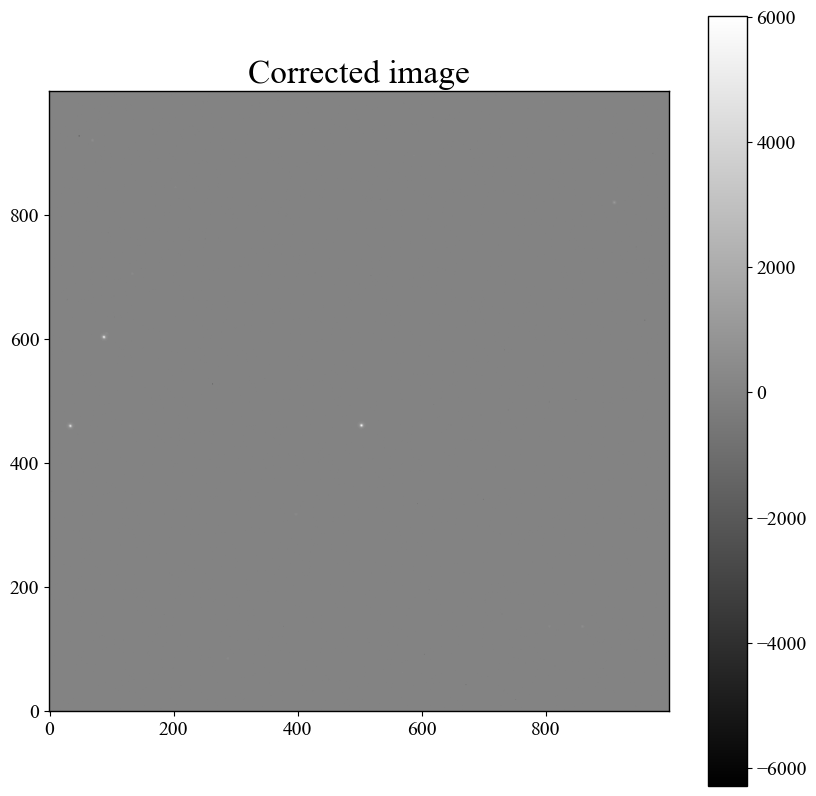

SX-UMa_LIGHT_2024-04-09T20-02-06Z_Chr-I_60s_-10.0C_W_0001.fits
SX-UMa_LIGHT_2024-04-10T01-56-34Z_Chr-I_60s_-10.0C_E_0053.fits
example_plate_solved.pdf
SX-UMa_LIGHT_2024-04-09T23-46-15Z_Chr-I_60s_-9.9C_W_0034.fits
SX-UMa_LIGHT_2024-04-10T02-30-17Z_Chr-I_60s_-10.0C_E_0058.fits
SX-UMa_LIGHT_2024-04-10T01-22-51Z_Chr-I_60s_-10.0C_E_0048.fits
SX-UMa_LIGHT_2024-04-10T02-56-39Z_Chr-I_60s_-9.9C_E_0062.fits
SX-UMa_LIGHT_2024-04-09T23-33-03Z_Chr-I_60s_-9.9C_W_0032.fits
SX-UMa_LIGHT_2024-04-10T00-56-27Z_Chr-I_60s_-10.0C_E_0044.fits
SX-UMa_LIGHT_2024-04-10T03-23-01Z_Chr-I_60s_-9.9C_E_0066.fits
SX-UMa_LIGHT_2024-04-10T01-16-16Z_Chr-I_60s_-10.0C_E_0047.fits
SX-UMa_LIGHT_2024-04-10T00-25-48Z_Chr-I_60s_-10.0C_W_0040.fits
SX-UMa_LIGHT_2024-04-10T02-43-29Z_Chr-I_60s_-9.9C_E_0060.fits
SX-UMa_LIGHT_2024-04-09T23-59-26Z_Chr-I_60s_-9.9C_W_0036.fits
SX-UMa_LIGHT_2024-04-09T23-12-16Z_Chr-I_60s_-9.9C_W_0029.fits
SX-UMa_LIGHT_2024-04-10T02-03-10Z_Chr-I_60s_-10.0C_E_0054.fits
SX-UMa_LIGHT_2024-04-10T03-36-55Z_Chr

In [57]:
calibration('SX UMa', 'Chr I', '60s',False)


In [60]:
platesolve('SX UMa', 'Chr G', True, False)

SX-UMa_LIGHT_2024-04-10T02-05-22Z_Chr-G_60s_-10.0C_E_0055.fits_c.fits
455
Solving........Success
56 15 25.23 13 26 13.392
SX-UMa_LIGHT_2024-04-09T23-48-28Z_Chr-G_60s_-10.0C_W_0035.fits_c.fits
412
Solving............Success
56 15 59.16 13 26 17.530
SX-UMa_LIGHT_2024-04-09T22-07-33Z_Chr-G_60s_-10.0C_W_0020.fits_c.fits
396
Solving.............Success
56 15 59.16 13 26 17.451
SX-UMa_LIGHT_2024-04-10T01-52-11Z_Chr-G_60s_-10.0C_E_0053.fits_c.fits
409
Solving.......Success
56 15 25.19 13 26 13.388
SX-UMa_LIGHT_2024-04-10T02-52-16Z_Chr-G_60s_-10.0C_E_0062.fits_c.fits
476
Solving...........Success
56 15 25.08 13 26 13.392
SX-UMa_LIGHT_2024-04-10T02-58-52Z_Chr-G_60s_-10.0C_E_0063.fits_c.fits
413
Solving...........Success
56 15 25.16 13 26 13.399
SX-UMa_LIGHT_2024-04-09T20-05-20Z_Chr-G_60s_-9.9C_W_0002.fits_c.fits
312
Solving.............Success
56 15 59.04 13 26 17.461
SX-UMa_LIGHT_2024-04-10T03-18-38Z_Chr-G_60s_-10.0C_E_0066.fits_c.fits
406
Solving................Success
56 15 25.23 13 26 13.38

SX-UMa_LIGHT_2024-04-10T02-05-22Z_Chr-G_60s_-10.0C_E_0055.fits_c.fits
56 15 25.23 13 26 13.392
 id xcentroid ycentroid sharpness  ... sky    peak      flux        mag      
--- --------- --------- ---------- ... --- --------- --------- --------------
290 35.507388 667.53504 0.46423965 ...   0 81443.479 2375.7568     -8.4395049
227 450.11132 525.18079 0.51790371 ...   0 81274.694 2332.9849     -8.4197798
  1 1.5802101 1.5803191 0.23010114 ...   0 32784.986 1557.2065     -7.9808655
  2 997.41986 1.5801985 0.23026366 ...   0 32788.441   1556.96     -7.9806936
454 1.5803408 997.41974 0.23025755 ...   0 32786.588 1556.6742     -7.9804944
455 997.41948 997.41958 0.22997596 ...   0 32774.142 1556.4965     -7.9803704
398 857.09441 884.64148 0.53039552 ...   0 38051.607 248.86162     -5.9898948
444 17.029434 984.85601 0.52754871 ...   0 36432.609 176.33604     -5.6158527
348 81.030722 769.73425 0.55984894 ...   0 35552.996 127.64396     -5.2650006
160 344.76044 382.10159 0.53874946 ...   0 3548

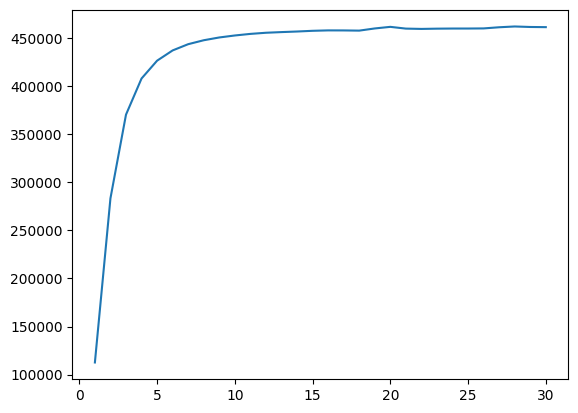

SX-UMa_LIGHT_2024-04-09T23-48-28Z_Chr-G_60s_-10.0C_W_0035.fits_c.fits
SX-UMa_LIGHT_2024-04-09T22-07-33Z_Chr-G_60s_-10.0C_W_0020.fits_c.fits
SX-UMa_LIGHT_2024-04-10T01-52-11Z_Chr-G_60s_-10.0C_E_0053.fits_c.fits
SX-UMa_LIGHT_2024-04-10T02-52-16Z_Chr-G_60s_-10.0C_E_0062.fits_c.fits
SX-UMa_LIGHT_2024-04-10T02-58-52Z_Chr-G_60s_-10.0C_E_0063.fits_c.fits
SX-UMa_LIGHT_2024-04-09T20-05-20Z_Chr-G_60s_-9.9C_W_0002.fits_c.fits
SX-UMa_LIGHT_2024-04-10T03-18-38Z_Chr-G_60s_-10.0C_E_0066.fits_c.fits
SX-UMa_LIGHT_2024-04-10T02-25-09Z_Chr-G_60s_-10.0C_E_0058.fits_c.fits
SX-UMa_LIGHT_2024-04-09T21-06-24Z_Chr-G_60s_-10.0C_W_0011.fits_c.fits
SX-UMa_LIGHT_2024-04-10T01-18-28Z_Chr-G_60s_-10.0C_E_0048.fits_c.fits
SX-UMa_LIGHT_2024-04-10T00-08-14Z_Chr-G_60s_-10.0C_W_0038.fits_c.fits
SX-UMa_LIGHT_2024-04-09T21-53-36Z_Chr-G_60s_-10.0C_W_0018.fits_c.fits
SX-UMa_LIGHT_2024-04-10T03-31-49Z_Chr-G_60s_-9.9C_E_0068.fits_c.fits
SX-UMa_LIGHT_2024-04-10T00-45-28Z_Chr-G_60s_-10.0C_E_0043.fits_c.fits
SX-UMa_LIGHT_2024-04-1

([2460410.587060185,
  2460410.491990741,
  2460410.421909722,
  2460410.5779050924,
  2460410.6196296294,
  2460410.624212963,
  2460410.337037037,
  2460410.637939815,
  2460410.600798611,
  2460410.3794444446,
  2460410.554490741,
  2460410.505717593,
  2460410.4122222224,
  2460410.6470949072,
  2460410.531574074,
  2460410.670486111,
  2460410.6058912035,
  2460410.449386574,
  2460410.3651967593,
  2460410.6333680553,
  2460410.5499074073,
  2460410.472962963,
  2460410.3697685185,
  2460410.431064815,
  2460410.5733333332,
  2460410.417326389,
  2460410.4264930557,
  2460410.454664352,
  2460410.435648148,
  2460410.540740741,
  2460410.360625,
  2460410.3840277777,
  2460410.596226852,
  2460410.501134259,
  2460410.5361574073,
  2460410.568240741,
  2460410.6567592593,
  2460410.559074074,
  2460410.468391204,
  2460410.652175926,
  2460410.6150578703,
  2460410.563657407,
  2460410.4874074073,
  2460410.4448032407,
  2460410.3886111113,
  2460410.407638889,
  2460410.59164351

In [1]:
from photometry import photometry

photometry('SX UMa','Chr G',12,1,False)

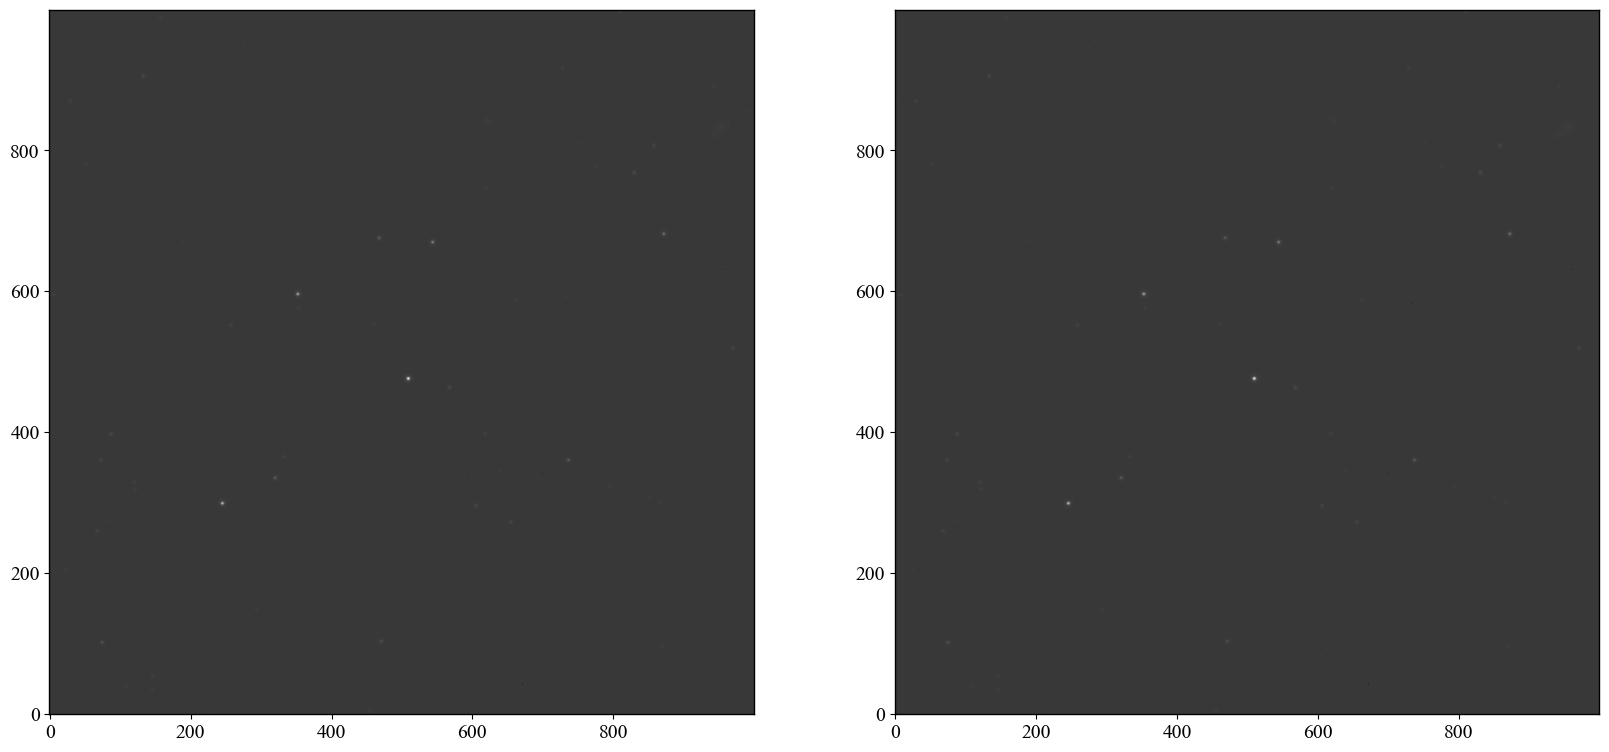

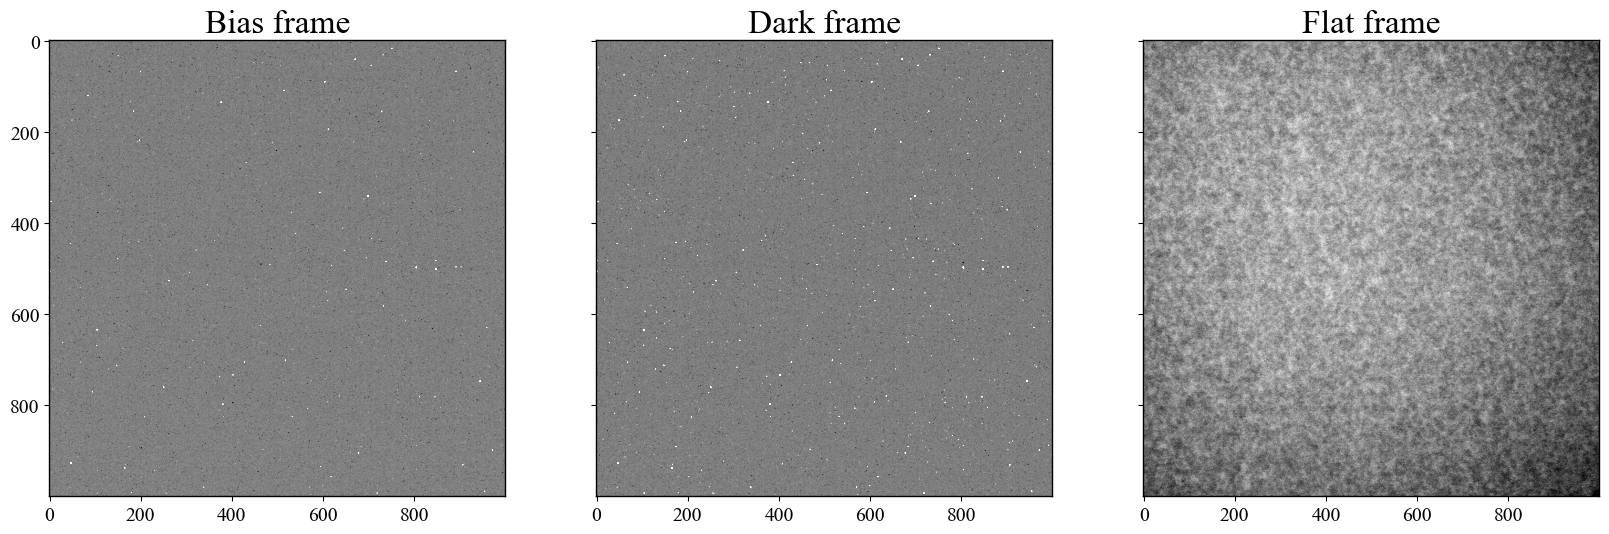

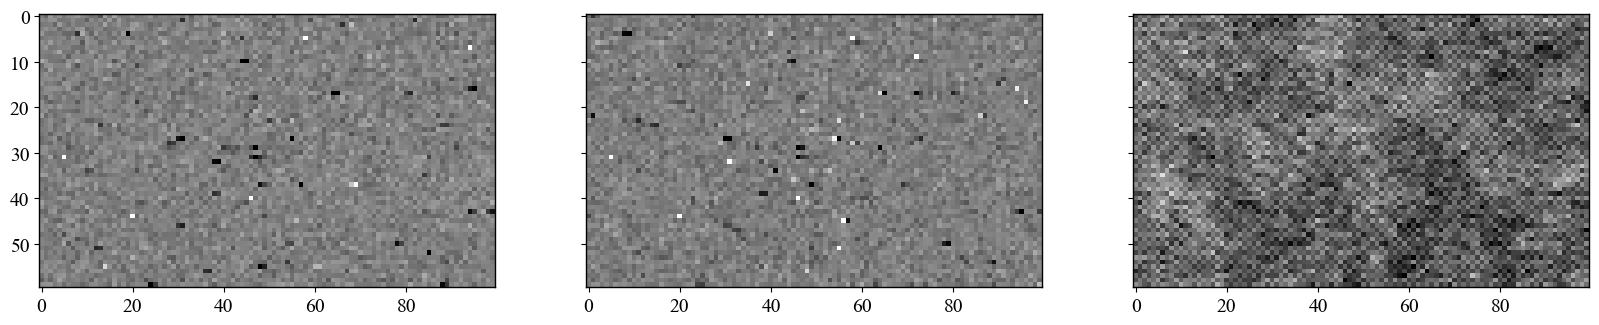

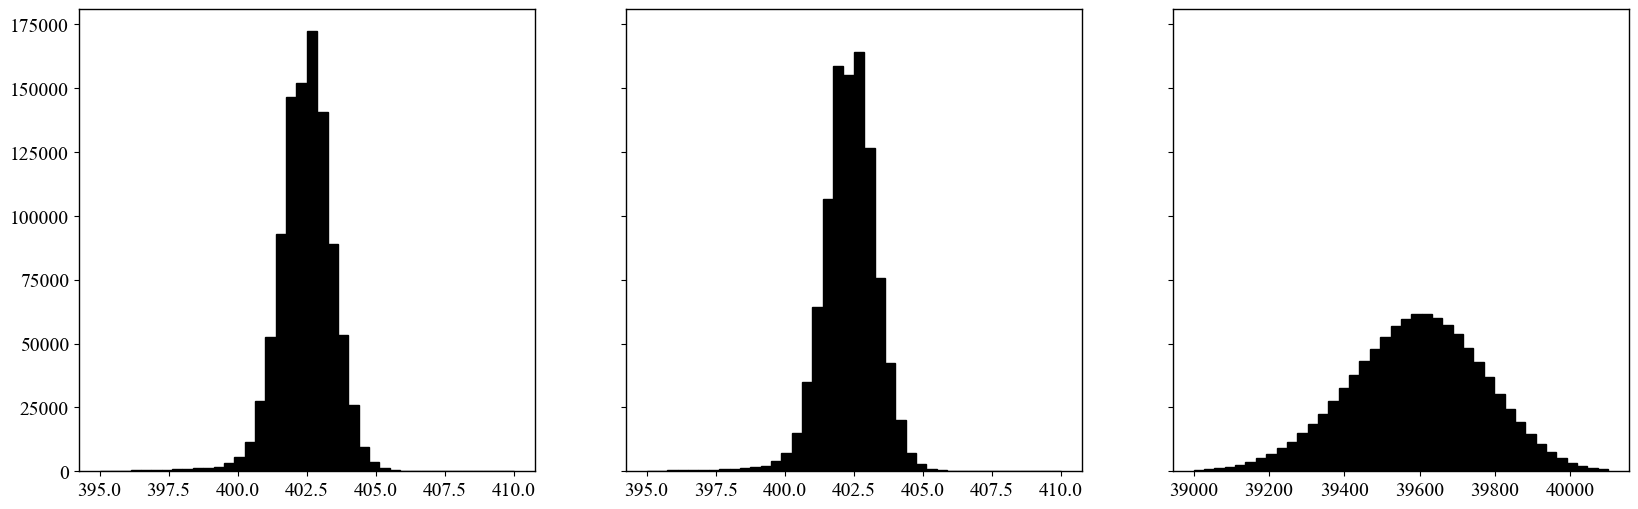

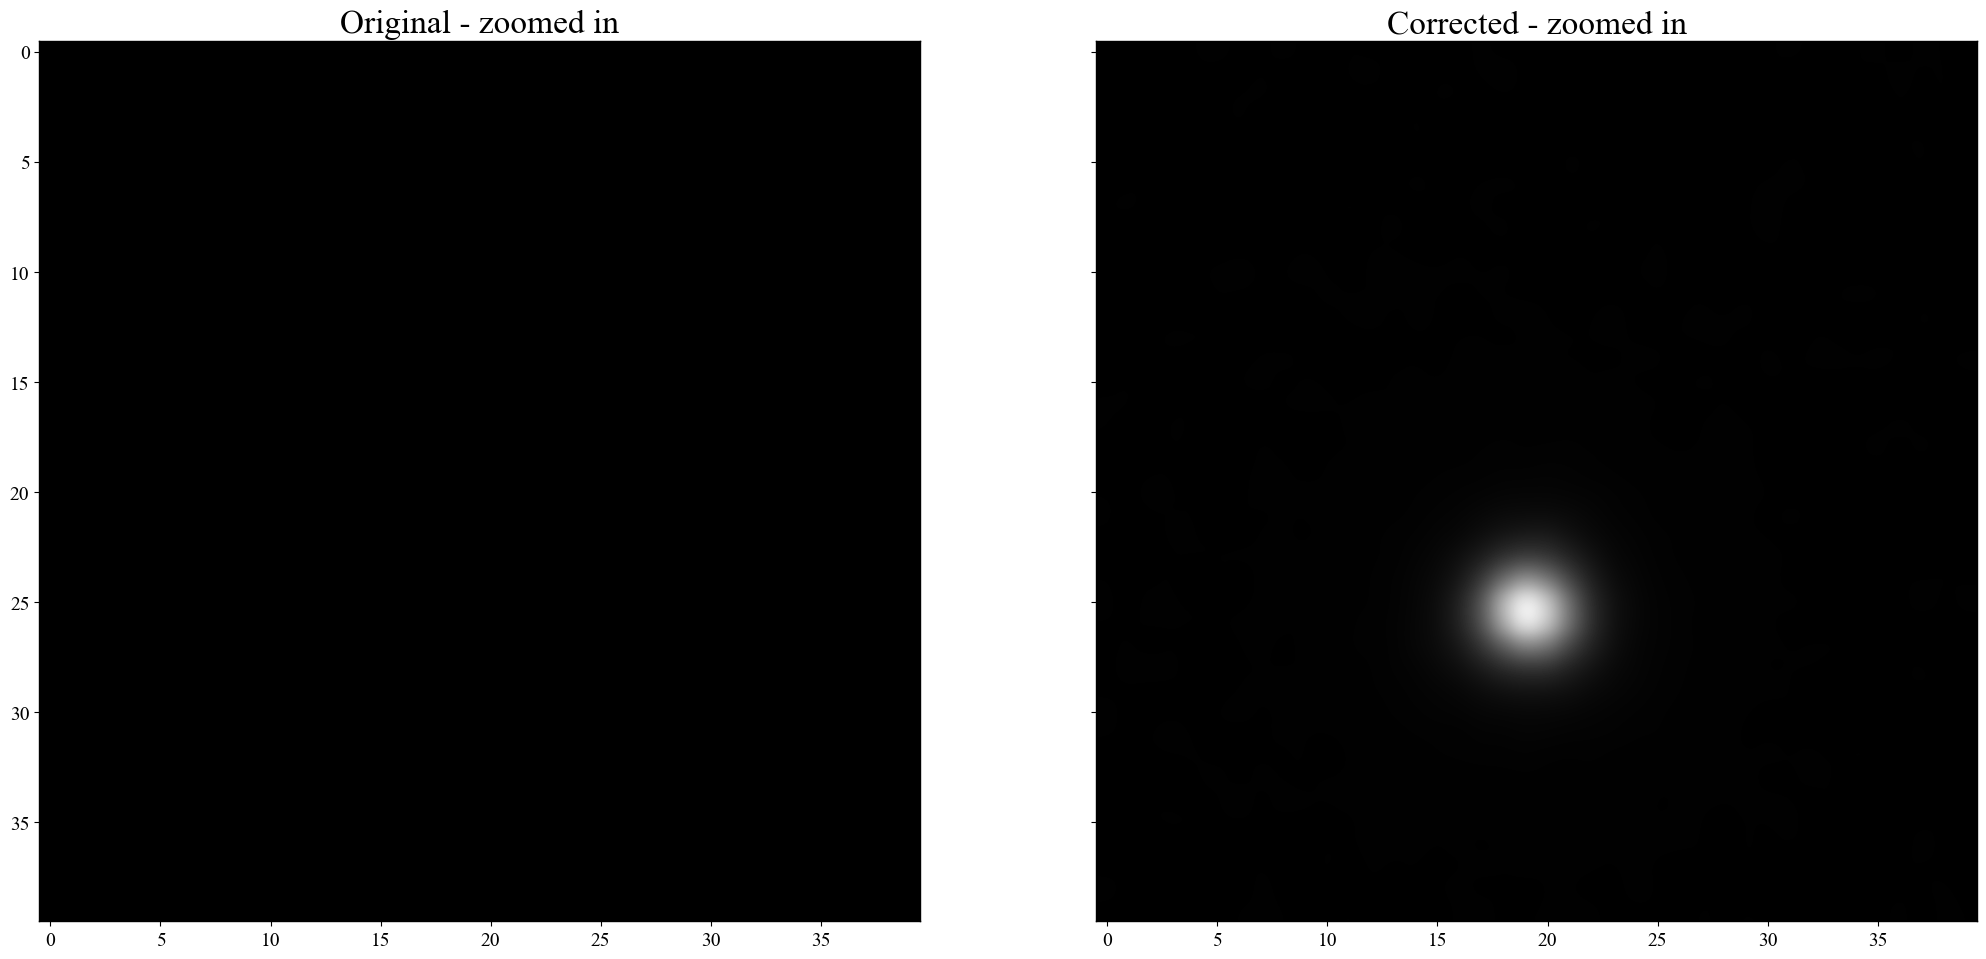

In [31]:
file = 'W-UMa_LIGHT_2024-01-23T20-02-58Z_Chr-G_10s_-9.9C_W_0001.fits'
data_path = '/Volumes/external_2T/corrected/NSVS7293918/Chr G/'
cal_path = '/Volumes/external_2T/calibration/2023-10/neg10c/master/'
list = os.listdir(data_path)
with fits.open(cal_path + 'flat_i_master.fits') as hdu:
    flat_i = hdu[0].data
with fits.open(cal_path + 'flat_g_master.fits') as hdu:
    flat_g = hdu[0].data
with fits.open(cal_path + 'flat_r_master.fits') as hdu:
    flat_r = hdu[0].data
with fits.open(cal_path + 'dark_flat_gr_3s_master.fits') as hdu:
    flat_dark = hdu[0].data
    
    avg_flat_dark = np.mean(flat_g-flat_dark)
with fits.open(cal_path + 'dark_' + '10s' + '_master.fits') as hdu:
    dark = hdu[0].data

with fits.open(data_path + list[0]) as hdu:
    data = hdu[0].data
    header = hdu[0].header




plt.figure(figsize=(20,10))
plt.subplot(1,2, 1)
plt.imshow(data, cmap='gray', origin='lower')
plt.subplot(1,2,2)
plt.imshow(data, cmap='gray', origin='lower')
plt.show()

bias_min = 395; bias_max = 410
dark_min = 395; dark_max = 410
flat_min = 39000; flat_max = 40100
nbins = 40

f1, (ax_bias, ax_dark, ax_flat) = plt.subplots(1, 3, sharey=True, figsize=(20,8))
plot_bias = ax_bias.imshow(flat_dark, vmin = bias_min, vmax=bias_max, cmap='gray')
plot_dark = ax_dark.imshow(dark, vmin = dark_min, vmax=dark_max, cmap='gray')
plot_flat = ax_flat.imshow(flat_g, vmin = flat_min, vmax=flat_max, cmap='gray')
ax_bias.set_title('Bias frame')
ax_dark.set_title('Dark frame')
ax_flat.set_title('Flat frame')

p=[800,800]                   
w=100; h=60

f2, (ax_bias_sub, ax_dark_sub, ax_flat_sub) = plt.subplots(1, 3, sharey=True, figsize=(20,8))
#f2, (ax_bias_sub, ax_dark_sub, ax_flat_sub) = plt.subplots(1, 3, sharey=True)

ax_bias_sub.imshow(flat_dark[p[1]:p[1]+h,p[0]:p[0]+w], vmin = bias_min, vmax=bias_max, cmap='gray', interpolation="none")
ax_dark_sub.imshow(dark[p[1]:p[1]+h,p[0]:p[0]+w], vmin = dark_min, vmax=dark_max, cmap='gray', interpolation="none")
ax_flat_sub.imshow(flat_g[p[1]:p[1]+h,p[0]:p[0]+w], vmin = flat_min, vmax=flat_max, cmap='gray', interpolation="none")


f3, (ax_bias_hist, ax_dark_hist, ax_flat_hist) = plt.subplots(1, 3, sharey=True, figsize=(20,6))
#f3, (ax_bias_hist, ax_dark_hist, ax_flat_hist) = plt.subplots(1, 3, sharey=True)

ax_bias_hist.hist(flat_dark.flatten(), bins=nbins, range=(bias_min, bias_max), fc='k', ec='k');
ax_dark_hist.hist(dark.flatten(), bins=nbins, range=(dark_min, dark_max), fc='k', ec='k');
ax_flat_hist.hist(flat_g.flatten(), bins=40, range=(flat_min, flat_max), fc='k', ec='k');


a=450
b=490
c=490
d=530
image_data_corrected_sub = data[a:b, c:d]
image_data_sub = data[a:b,a:b]

cmin_raw = 37000; cmax_raw = 47000

cmin_corrected = 37000; cmax_corrected = 47000


fig1, (ax_raw, ax_corrected) = plt.subplots(1,2, sharey=True, figsize=(25,20))

ax_raw.set_title('Original - zoomed in')
ax_corrected.set_title('Corrected - zoomed in')
ax_raw.imshow(image_data_sub,  vmin = cmin_raw, vmax=cmax_raw, cmap='gray', interpolation='none')#, vmin = cmin_corrected, vmax=cmax_corrected
ax_corrected.imshow(image_data_corrected_sub, cmap='gray',interpolation='quadric')#, vmin = cmin_corrected, vmax=cmax_corrected

    